# Walkthrough

The magcolloids  module provides the class `sim`, which contains the simulation parameters.
After a `sim` object is created, it can be used to generate a lammps input script, run it and read it's results. 

The basic usage of the module consists of defining a `sim` object.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.insert(0, '../../')

import magcolloids as mgc

%reload_ext autoreload
%autoreload 2

### To run simulations from any directory
In the imports above, the command `sys.path.insert(0, '../../')` adds a folder to the current kernel's path. This is useful if you want to use the program without placing the folder in the system path. The kernel's path is reset to default when the kernel is restarted. 

## Units

The package defines a set of units using [`pint`](https://pint.readthedocs.io/en/latest/). This helps keep consistent units across the program, and allows the user to introduce the parameter in different units. 

`pint` works by defining a unit registry. The unit registry used within the package is accessed by:

In [2]:
ureg = mgc.ureg

To assign a unit to a quantity its as simple as multiplying. For example:

In [3]:
d = 3*ureg.um
print(d)

3 micrometer


Afterwards, we can convert this to other units, as in:

In [4]:
d.to(ureg.m)

3e-06 <Unit('meter')>

## Parameter objects

There are three objects that need to be defined before a simulation can be performed:
* `particles`
* `field`
* `world`


Details of the definition can be found in the API.

### `particles` Object
A `particles` object defines the properties of a set of particles. For a simulation, several `particles` objects can be used (future), to have polydisperse mixture of particles. The object also includes an array of initial conditions. 

In [5]:
region, initial_conditions = mgc.initial_setup(150, packing = 0.3, height = 4, radius = 1.4)

particles = mgc.particles(
    initial_conditions*ureg.um,
    radius = 1.4*ureg.um,
    susceptibility = 0.4,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 1000*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

In the cell above, we use the function `initial_setup` that creates a region of a certain size, and a set of particles. This function is useful for setting the initial conditions of a system with a predetermined packing fraction. The resulting array can be directly input to the `copy` method to create many particles. 

Notice how most of the parameters have units. The susceptibility is an exception, because it is an adimentional unit. 

#### Temperature of the `particles` object

Note that the `temperature` defined above is only a way to convert the diffusion coefficient to a drag coefficient. The actual temperature of the system is defined below in the `world` parameters. Another alternative is to define the `drag` coefficient, and then the `temperature` parameter is not necessary here.

### `field` Object

The `field` object defines exclusively the magnetic field. The easiest option is to use the definition below, where the parameters of `magnitude`, `frequency` and `angle` are used to calculate a rotating field with a $\hat{z}$ component. There are three more arguments, `fieldx`, `fieldy`, `fieldz`, which can accept strings to be evaluated as lammps variables (see below). The field magnitude can be given in any units, but should be the magnetic flux density $\bf{B}$, as opposed to the magnetic field intensity $\bf{H}$

As an alternative, these values can also be passed as lammps parseable strings (see details of how to define functions in lammps in the [lammps docs](http://lammps.sandia.gov/doc/variable.html)). The biggest disadvantage of this approach, is that the units can't be checked for consistency, and they have to be given in $\textrm{pg}, $\mu{}\textrm{m}$, and $\mu\textrm{s}$. The angle must be in radians

Furthermore, the magnitude of the field has strange units in lammps (due to their deffinition of the dipole-dipole interaction), and must be therefore given by:

$$\bf{H}_{lammps} = \frac{\bf{B}_{m\mathrm{T}}}{\mu_0}\times10/2.99$$.

All this should be clarified in the future. For the moment, a simple rotating field can be defined by:

In [6]:
field = mgc.field(magnitude = 5*ureg.mT, frequency = 10*ureg.Hz, angle = 15*ureg.degrees)

### world Object

The `world` object defines characteristics of the world like the temperature, the region, and the interaction parameters. In the example below we use the `region` array defined before by the `initial_conditions` command. 

It's important to mention that the seed is defined when a world is defined, so that if the world is reused, the seed remains the same. However, the `world` object has a `reset_seed` method that can be used to set a new seed. 

In [7]:
world = mgc.world(particles, temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 20*ureg.um)

Finaly all the three objects, `particle_array`, `field`, and `world` can be used to create a simulation object. 

## `simulation` Object

The simulation object accepts the final set of parameters, such as the total time, the simulation type, the number of parallel cores, or the place where the simulation has to be saved. 

In [8]:
sim = mgc.sim(dir_name = "/Users/aortiza/Desktop/",
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = 60*ureg.s,
       particles = particles, world = world, field = field)

Before running the simulation, the simulation object needs to create the scripts. This method creates a lammps input script.

In [9]:
sim.generate_scripts()

The `run()` method uses the operating system interface to run the script generated in the command line. It saves the output in the same directory, in a `.lammpstrj` file.

In [10]:
sim.run()

## `simulation` load

To load the simulation, the easiest and more efficient option is to use the `load` method

In [11]:
sim.load()

The `load` method creates a subobject `lazy_read`, that stores the position in the `.lammpstrj` file of every timestep. This allows us to selectively load certain frames faster, which is very useful for large files.

In [12]:
trj = sim.lazy_read[::10]

## Displaying results

There are several ways to display results in the support functions. However, the most common one is as an animation. For this, we can use the `display_animation_direct()` function:

In [13]:
from IPython.display import HTML

HTML(mgc.display_animation_direct(sim,trj,speedup=1))

Be careful. This function returns a HTML5 video object. If the `HTML` function is not used, jupyter will try to display as a string the contents of the HTML5, wich will likely result in a hung system. 

# Checking that simulation has correct parameters.

Bellow we do some tests to the simulation framework to ensure that things are working

## Freely diffusing particle

We simulate a freely diffusing particle in three dimensions, and we compare the resulting MSD to the diffusion coefficient that we give as input. This tells us that the damping coefficient is being set properly. 

In [14]:
region, initial_conditions = mgc.initial_setup(9, packing = 0.3, height = 4, radius = 1.4)

initial_conditions = [[0,0,0]]
particles = mgc.particles(
    initial_conditions*ureg.um,
    radius = 1.4*ureg.um,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

field = mgc.field(magnitude = 0*ureg.mT, frequency = 10*ureg.Hz, angle = 15*ureg.degrees)
world = mgc.world(particles, temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['s','s','s'], walls = [False,False,False],
                  dipole_cutoff = 20*ureg.um)

sim = mgc.sim(dir_name = "/Users/aortiza/Desktop/",
        timestep = 1e-3*ureg.s, framerate = 30*ureg.Hz, total_time = 60*ureg.s,
        particles = particles, world = world, field = field)

sim.generate_scripts()

In [15]:
sim.run()

In [16]:
sim.load()
trj = sim.lazy_read[::]

Text(0, 0.5, 'z $\\mu{}m$')

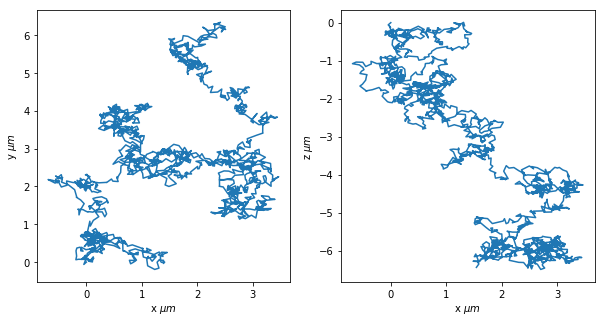

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.plot(trj.x,trj.y)
ax1.set_xlabel(r"x $\mu{}m$")
ax1.set_ylabel(r"y $\mu{}m$")

ax2.plot(trj.x,trj.z)
ax2.set_xlabel(r"x $\mu{}m$")
ax2.set_ylabel(r"z $\mu{}m$")


### MSD and Diffusion Coefficient

In [18]:
import trackpy as tp

In [19]:
idx = pd.IndexSlice
trj_msd = trj.loc[idx[:,1],:].filter(["x","y"])
trj_msd = trj_msd.reset_index(level=[1])
trj_msd['frame'] = range(len(trj_msd.index))

run_step = int(np.round(sim.total_time.to(ureg.s)/sim.timestep.to(ureg.s)))
fps = sim.framerate.to(ureg.Hz).magnitude

msd = tp.msd(trj_msd,1,fps,max_lagtime=int(run_step))

C:\Users\aortiza\Anaconda3\lib\site-packages\pint\quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


Text(0, 0.5, 'MSD\xa0[$\\mu{}m^2$]')

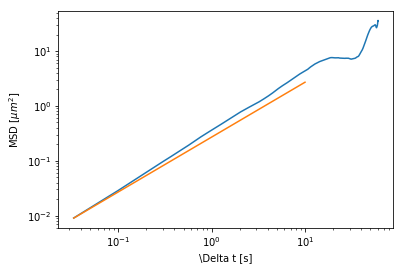

In [20]:
D = (4*(ureg.pN*ureg.nm)/sim.particles.drag).to(ureg.um**2/ureg.s)

plt.loglog(msd.lagt,msd.msd)
plt.loglog([1/fps,10],4*D*np.array([1/fps,10]));
plt.xlabel("\Delta t [s]")
plt.ylabel("MSD [$\mu{}m^2$]")

Notice here that the diffusion is being calculated as $MSD = 4Dt$. This is because the MSD calculated by the [`trackpy`](https://soft-matter.github.io/trackpy/v0.3.2/tutorial/walkthrough.html) package is in 2D. 

## Two magnetic particles

We now test that the dipole moment is correct by placing two particles close to each other and observing the distance between then. We do this at very low temperature ($1K$) to obtain almost deterministic curves. We define two confining walls to prevent the particles from towering.

In [21]:
region, initial_conditions =mgc.initial_setup(9, packing = 0.3, height = 3, radius = 1.4)

initial_conditions = [[-1.4,0,0],[1.4,0,0]]
particles = mgc.particles(
    initial_conditions*ureg.um,
    radius = 1.4*ureg.um,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

field = mgc.field(magnitude = 3*ureg.mT, frequency = 0*ureg.Hz, angle = 0*ureg.degrees)
world = mgc.world(particles, temperature = 1*ureg.K,
                  region=region*ureg.um, boundaries = ['s','s','f'], walls = [False,False,True],
                  dipole_cutoff = 20*ureg.um)

sim = mgc.sim(dir_name = "/Users/aortiza/Desktop/",
        timestep = 1e-3*ureg.s, framerate = 30*ureg.Hz, total_time = 60*ureg.s,
        particles = particles, world = world, field = field)

sim.generate_scripts()

In [22]:
sim.run()

In [23]:
sim.load()
trj = sim.lazy_read[::]

In [24]:
distance = (
    trj.loc[idx[:,1],:].reset_index(level=[1]) - \
    trj.loc[idx[:,2],:].reset_index(level=[1]) ).filter(["x","y","z"])
distance = np.sqrt(distance.x**2+distance.y**2+distance.z**2)

The model for the distance between the dipoles, as a function of time, is well known and often used for susceptibility calibration in experiments. The distance is given by:

$$d = \sqrt[5]{5At+(2\sigma)^5}$$

where $\sigma$ is the particle radius, $A$ is:

$$A \equiv \frac{8\pi}{3\mu_0\gamma}\left(\sigma^3\chi\bf{B}\right)^2$$

and $\gamma = \frac{k_bT}{D}$ is the drag coefficient.

Text(0, 0.5, 'distance [$\\mu{m}$]')

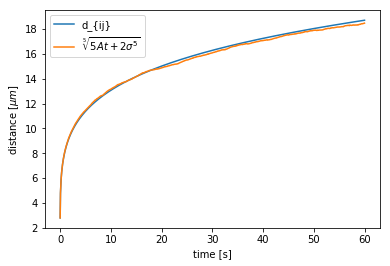

In [25]:
sgm = sim.particles.radius
B = sim.field.magnitude
drag = sim.particles.drag
mu0 = (4e5*np.pi)*ureg.pN/ureg.A**2
xi = sim.particles.susceptibility

A = (8*np.pi/(3*mu0*drag)*(sgm**3*xi*B)**2).to(ureg.um**5/ureg.s)

t = np.linspace(0,60,1000)*ureg.s
plt.plot(t,(5*A*t+(2*sgm)**5)**(1/5))
plt.plot(distance.index.values*sim.timestep,distance.values)

plt.legend(['d_{ij}','$\sqrt[5]{5At+2\sigma^5}$'])
plt.xlabel("time [s]")
plt.ylabel("distance [$\mu{m}$]")

The agreement between the two curves tells us that the dipolar interaction is being calculated correctly.

## Gravity

The prescence of gravity in the simulations is the recent addition. The gravitational force is calculated from the density parameter, which in reality corresponds to the excess density ($\rho_{ex} \equiv \rho_{colloid}-\rho_{medium}$)
To see if it is working correctly, we run a simulation of many particles in a losely packed system. 

In [26]:
region, initial_conditions = mgc.initial_setup(150, packing = 0.1, height = 4, radius = 1.4)

particles = mgc.particles(
    initial_conditions*ureg.um,
    radius = 1.4*ureg.um,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 1e3*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

field = mgc.field(magnitude = 5*ureg.mT, frequency = 10*ureg.Hz, angle = 15*ureg.degrees)
world = mgc.world(particles, temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 20*ureg.um)


sim = mgc.sim(dir_name = "/Users/aortiza/Desktop/",
        timestep = 1e-3*ureg.s, framerate = 30*ureg.Hz, total_time = 60*ureg.s,
        particles = particles, world = world, field = field)

sim.generate_scripts()

In [27]:
sim.run()

In [28]:
sim.load()
trj = sim.lazy_read[::10]

In [29]:
HTML(mgc.display_animation_direct(sim,trj,speedup=1))

We see how many particles are now in the lower configuration. It will be interesting to observe the structure formed by the particles that are in the top. 